In [1]:
%matplotlib inline

In [2]:
###############################################################################
"""
Python Glacier Evolution Model "PyGEM" V1.0
Prepared by David Rounce with support from Regine Hock.
This work was funded under the NASA HiMAT project (INSERT PROJECT #).

PyGEM is an open source glacier evolution model written in python.  Model
details come from Radic et al. (2013), Bliss et al. (2014), and Huss and Hock
(2015).
"""
###############################################################################
# This is the main script that provides the architecture and framework for all
# of the model runs. All input data is included in a separate module called
# pygem_input.py. It is recommended to not make any changes to this file unless
# you are a PyGEM developer and making changes to the model architecture.
#
#========== IMPORT PACKAGES ==================================================
# Various packages are used to provide the proper architecture and framework
# for the calculations used in this script. Some packages (e.g., datetime) are
# included in order to speed of calculations and simplify code
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import os # os is used with re to find name matches
import re # see os
import xarray as xr
#========= IMPORT MODEL INPUTS ===============================================
from pygem_input import *
    # import all data
    # pygem_input.py contains all the input data
#========== IMPORT FUNCTIONS FROM MODULES ====================================
import pygemfxns_modelsetup as modelsetup
import pygemfxns_climate as climate
import pygemfxns_massbalance as massbalance

In [3]:
#========== OTHER STEPS ======================================================
# Other steps:
# Geodetic mass balance file path
# ???[Create input script full of option list]???
#       - Select regions: (Option 1 - default regions from RGI inventory)
#                         (Option 2 - custom regions)
#       - Select climate data:
#           - climate data source/file name
#           - climate data resolution
#           - sampling scheme (nearest neighbor, etc.)
#       - Model run type: (Option 1 - calibration)
#                         (Option 2 - simulation)
#

#========== LIST OF OUTPUT ===================================================
# Create a list of outputs (.csv or .txt files) that the user can choose from
# depending on what they are using the model for or want to see:
#    1. Time series of all variables for each grid point (x,y,z) of each glacier
#       and every time step
#       (--> comparing with point balances)
#    2. Time series of all variables for elevation bands if spatial
#       discretization is elevation bands (x,y,z) of each glacier and every time
#       step
#       (--> comparing with profiles)
#    3. as above but all variables averaged over current single glacier surfaces
#       (--> comparing with geodetic mass balances of glaciers)
#    4. Time series of all variables averaged over region
#       (--> comparison to GRACE)
#    5. Time series of seasonal balance for individual glaciers
#       (--> comparison to WGMS data)
# Also develop output log file, i.e., file that states input parameters,
# date of model run, model options selected, and any errors that may have come
# up (e.g., precipitation corrected because negative value, etc.)

#========== MODEL RUN DETAILS ================================================
# The model is run through a series of steps:
#   > Step 01: Region/Glaciers Selection
#              The user needs to define the region/glaciers that will be used in
#              the model run.  The user has the option of choosing the standard
#              RGI regions or defining their own.
#   > Step 02: Model Time Frame
#              The user should consider the time step and duration of the model
#              run along with any calibration product and/or model spinup that
#              may be included as well.
#   > Step 03: Climate Data
#              The user has the option to choose the type of climate data being
#              used in the model run, and how that data will be downscaled to
#              the glacier and bins.
#   > Step 04: Glacier Evolution
#              The heart of the model is the glacier evolution, which includes
#              calculating the specific mass balance, the surface type, and any
#              changes to the size of the glacier (glacier dynamics). The user
#              has many options for how this aspect of the model is run.
#   > Others: model output? model input?

In [4]:
#----- STEP ONE: MODEL REGION/GLACIERS ---------------------------------------
# Step one involves the selection of the regions and glaciers used in the model.
# Regions/glacier included in the model run will be defined using the Randolph
#   Glacier inventory.  For more information, see:
#     https://www.glims.org/RGI/ (RGI Consortium, 2017)
# In step one, the model will:
#   > select glaciers included in model run

# Select glaciers that are included in the model run
# Glacier Selection Options:
#   > 1 (default) - enter numbers associated with RGI V6.0 and select
#                   glaciers accordingly
#   > 2 - glaciers/regions selected via shapefile
#   > 3 - glaciers/regions selected via new table (other inventory)
#
if option_glacier_selection == 1:
    main_glac_rgi = modelsetup.selectglaciersrgitable()
elif option_glacier_selection == 2:
    # OPTION 2: CUSTOMIZE REGIONS USING A SHAPEFILE that specifies the
    #           various regions according to the RGI IDs, i.e., add an
    #           additional column to the RGI table.
    # ??? [INSERT CODE FOR IMPORTING A SHAPEFILE] ???
    #   (1) import shapefile with custom boundaries, (2) grab the RGIIDs
    #   of glaciers that are in these boundaries, (3) perform calibration
    #   using these alternative boundaries that may (or may not) be more
    #   representative of regional processes/climate
    #   Note: this is really only important for calibration purposes and
    #         post-processing when you want to show results over specific
    #         regions.
    # Development Note: if create another method for selecting glaciers,
    #                   make sure that update way to select glacier
    #                   hypsometry as well.
    print('\n\tMODEL ERROR (selectglaciersrgi): this option to use'
          '\n\tshapefiles to select glaciers has not been coded yet.'
          '\n\tPlease choose an option that exists. Exiting model run.\n')
    exit()
else:
    # Should add options to make regions consistent with Brun et al. (2017),
    # which used ASTER DEMs to get mass balance of 92% of the HMA glaciers.
    print('\n\tModel Error (selectglaciersrgi): please choose an option'
          '\n\tthat exists for selecting glaciers. Exiting model run.\n')
    exit()


This study is only focusing on glaciers ['03473', '03733'] in region [15].
The 'select_rgi_glaciers' function has finished.


In [5]:
#----- STEP TWO: ADDITIONAL MODEL SETUP --------------------------------------
# Step two runs more functions related to the model setup. This section has been
#   separated from the selection of the model region/glaciers in order to
#   keep the input organized and easy to read.
# In step two, the model will:
#   > select glacier hypsometry
#   > define the model time frame
#   > define the initial surface type

# Glacier hypsometry
# main_glac_hyps = modelsetup.hypsometryglaciers(main_glac_rgi)
    # Note: need to adjust this hypsometry into separate functions such that it
    #       is easier to follow.
# AUTOMATE THIS TO LOAD THEM IN INSTEAD OF CHOOSING THEM
# main_glac_hyps = pd.read_csv(hyps_filepath + 'RGI_13_area_test20170905.csv')
ds = pd.read_csv(hyps_filepath + 'bands_10m_DRR/area_15_Huss_SouthAsiaEast_10m.csv')
# print(ds.head())
# Select glaciers based on 01Index value from main_glac_rgi table
glac_hyps_table = pd.DataFrame()
for glacier in range(len(main_glac_rgi)):
    if glac_hyps_table.empty:
        glac_hyps_table = ds.loc[main_glac_rgi.loc[glacier,'O1Index']]
    else:
        glac_hyps_table = pd.concat([glac_hyps_table, ds.loc[main_glac_rgi.loc[glacier,'O1Index']]], axis=1)
glac_hyps_table = glac_hyps_table.transpose()
# print(glac_hyps_table.head())
# Clean up table and re-index
# Reset index to be GlacNo
glac_hyps_table.reset_index(drop=True, inplace=True)
glac_hyps_table.index.name = indexname
# Drop columns that are not elevation bins
glac_hyps_table.drop(['RGI-ID','Cont_range'], axis=1, inplace=True)
# Make sure columns are integers
glac_hyps_table.columns = glac_hyps_table.columns.values.astype(int)
# Change NAN from -99 to 0
glac_hyps_table[glac_hyps_table==-99] = 0.
# Add empty rows such that bins are consistent for every region
bins = np.arange(int(binsize/2),9000,binsize)
# print(glac_hyps_table.shape[1])
# Find when bins agree and enter
main_glac_hyps = pd.DataFrame(0, index=glac_hyps_table.index, columns=bins)
# print(main_glac_hyps.shape)
for cols in range(main_glac_hyps.shape[1]):
    column_value = main_glac_hyps.columns.values[cols]
    if column_value in glac_hyps_table.columns:
        main_glac_hyps.loc[:, column_value] = glac_hyps_table.loc[:, column_value]
print(main_glac_hyps.loc[:,5005:5065])

          5005    5015     5025    5035     5045     5055     5065
GlacNo                                                            
0         0.55  0.4875    0.375  0.3925   0.2925   0.2975    0.355
1       0.1275   0.105  0.12062  0.0875  0.11688  0.08625  0.09813


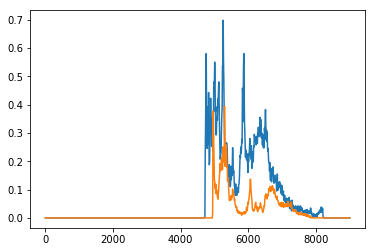

In [6]:
# Plot glacier hypsometry using matplotlib
plt.plot(main_glac_hyps.columns.values, main_glac_hyps.loc[0])
plt.plot(main_glac_hyps.columns.values, main_glac_hyps.loc[1])

In [7]:
# Glacier initial ice thickness
# AUTOMATE THIS WITH A FUNCTION (same function as hypsometry with different input)
# main_glac_icethickness = pd.read_csv(hyps_filepath +
#                                      'RGI_13_thickness_test20170905.csv')
ds2 = pd.read_csv(hyps_filepath + 'bands_10m_DRR/thickness_15_Huss_SouthAsiaEast_10m.csv')
# print(ds2.head())
# Select glaciers based on 01Index value from main_glac_rgi table
glac_thickness_table = pd.DataFrame()
for glacier in range(len(main_glac_rgi)):
    if glac_thickness_table.empty:
        glac_thickness_table = ds2.loc[main_glac_rgi.loc[glacier,'O1Index']]
    else:
        glac_thickness_table = pd.concat([glac_thickness_table, ds2.loc[main_glac_rgi.loc[glacier,'O1Index']]], axis=1)
glac_thickness_table = glac_thickness_table.transpose()
# print(glac_thickness_table.head())
# Clean up table and re-index
# Reset index to be GlacNo
glac_thickness_table.reset_index(drop=True, inplace=True)
glac_thickness_table.index.name = indexname
# Drop columns that are not elevation bins
glac_thickness_table.drop(['RGI-ID','Cont_range'], axis=1, inplace=True)
# Make sure columns are integers
glac_thickness_table.columns = glac_thickness_table.columns.values.astype(int)
# Change NAN from -99 to 0
glac_thickness_table[glac_thickness_table==-99] = 0
# Add empty rows such that bins are consistent for every region
# bins = np.arange(int(binsize/2),9000,binsize)
# print(glac_thickness_table.shape[1])
# Find when bins agree and enter
main_glac_icethickness = pd.DataFrame(0, index=glac_thickness_table.index, columns=bins)
# print(main_glac_thickness.shape)
for cols in range(main_glac_icethickness.shape[1]):
    column_value = main_glac_icethickness.columns.values[cols]
    if column_value in glac_thickness_table.columns:
        main_glac_icethickness.loc[:, column_value] = glac_thickness_table.loc[:, column_value]
print(main_glac_icethickness.loc[:,5005:5065])
# print(glac_thickness_table.head())

         5005   5015   5025   5035   5045   5055   5065
GlacNo                                                 
0       185.5  178.5  172.9  175.7  179.4  179.7  188.7
1       104.8  112.4  109.9  106.9  103.2  102.4   97.5


In [8]:
# ADD OPTION FOR VOLUME-AREA SCALING

# Glacier total initial volume
main_glac_rgi['Volume'] = (
    (main_glac_hyps * main_glac_icethickness/1000).sum(axis=1))
    # volume [km3] = area[km2] * thickness[m] * (1 [km] / 1000 [m])

print(main_glac_rgi.head(),'\n')

        O1Index           RGIId     CenLon     CenLat  O1Region  O2Region  \
GlacNo                                                                      
0          3472  RGI60-15.03473  86.715912  28.089468        15         2   
1          3732  RGI60-15.03733  86.903244  27.974716        15         2   

          Area  Zmin  Zmax  Zmed  Slope  Aspect   Lmax    Volume  
GlacNo                                                            
0       61.054  4702  8181  5815   16.5     180  18285  7.057732  
1       19.097  4926  7870  5568   17.5     262  15396  1.976989   



In [9]:
# Model time frame
#   Set up table of dates. These dates are used as column headers for many other
#   variables in the model run, so it's important to be an initial step.
dates_table, start_date, end_date = modelsetup.datesmodelrun(option_wateryear, option_leapyear)
print(dates_table.head(15))

The 'datesmodelrun' function has finished.
               date  year  month  daysinmonth  wateryear
timestep                                                
0        2000-10-01  2000     10           31       2001
1        2000-11-01  2000     11           30       2001
2        2000-12-01  2000     12           31       2001
3        2001-01-01  2001      1           31       2001
4        2001-02-01  2001      2           28       2001
5        2001-03-01  2001      3           31       2001
6        2001-04-01  2001      4           30       2001
7        2001-05-01  2001      5           31       2001
8        2001-06-01  2001      6           30       2001
9        2001-07-01  2001      7           31       2001
10       2001-08-01  2001      8           31       2001
11       2001-09-01  2001      9           30       2001
12       2001-10-01  2001     10           31       2002
13       2001-11-01  2001     11           30       2002
14       2001-12-01  2001     12           31

In [10]:
# # Trouble shooting surftype notes
# main_glac_surftypeinit = main_glac_hyps.copy()
# # # Rows are each glacier, and columns are elevation bins
# # # Loop through each glacier (row) and elevation bin (column) and define the
# # # initial surface type (snow, firn, ice, or debris)
# 
# for glac in range(main_glac_surftypeinit.shape[0]):
#     elev_med = main_glac_rgi.loc[glac,'Zmed']
#     for col in range(main_glac_surftypeinit.shape[1]):
#         elev_bin = int(main_glac_hyps.columns.values[col])
#         if main_glac_hyps.iloc[glac,col] > 0:
#             if elev_bin <= elev_med:
#                 main_glac_surftypeinit.iloc[glac,col] = 1
#             else:
#                 main_glac_surftypeinit.iloc[glac,col] = 2
# # If firn is included, then specify initial firn conditions
# main_glac_surftypeinit = main_glac_surftypeinit.astype(int)
# if option_surfacetype_firn == 1:
#     main_glac_surftypeinit[main_glac_surftypeinit == 2] = 3
#         # everything initially considered snow is considered firn, i.e., the
#         # model initially assumes there is no snow on the surface anywhere.
# # If debris is included, then specify initial debris conditions
# if option_surfacetype_debris == 1:
#     print('Need to code the model to include debris. This option does not '
#           'currently exist.  Please choose an option that does.\nExiting '
#           'the model run.')
#     exit()
#     # One way to include debris would be to simply have debris cover maps
#     # and state that the debris retards melting as a fraction of melt.  It
#     # could also be DDF_debris as an additional calibration tool. Lastly,
#     # if debris thickness maps are generated, could be an exponential
#     # function with the DDF_ice as a term that way DDF_debris could capture
#     # the spatial variations in debris thickness that the maps supply.
# print(main_glac_surftypeinit.loc[:,5005:5065])

In [11]:
# Initial surface type
main_glac_surftypeinit = modelsetup.surfacetypeglacinitial(
                                                option_surfacetype_initial,
                                                option_surfacetype_firn,
                                                option_surfacetype_debris,
                                                main_glac_rgi,
                                                main_glac_hyps)

The 'initialsurfacetype' function has finished.


In [12]:
# Mass balance estimates from High-res DEMs
mb_filepath = '../DEMs/hma_mb_20170717_1846.csv'
# mb_filepath = os.path.dirname(__file__) + '/../DEMs/hma_mb_20170717_1846.csv'
main_glac_mb_raw = pd.read_csv(mb_filepath)
print(main_glac_mb_raw.head())

   # glacnum           x          y    z_med    z_p16    z_p84  mb_mwea  \
0   14.19942  -927804.01  -35168.38  7496.07  7415.89  7650.54     1.02   
1   14.23897 -1157128.32  106023.79  7408.39  7353.91  7467.04     1.74   
2   15.05141   -44297.11 -837269.98  7349.13  7026.94  7473.72     0.64   
3   14.19948  -929689.48  -36435.04  7249.72  6932.15  7544.95     0.53   
4   14.23883 -1157892.34  106248.27  7193.10  7071.63  7298.66     1.12   

   area_km2       t1      t2     dt  
0      2.82  2000.11  2015.0  14.89  
1      0.10  2000.11  2015.0  14.89  
2      1.57  2000.11  2015.0  14.89  
3      2.29  2000.11  2015.0  14.89  
4      0.38  2000.11  2015.0  14.89  


In [13]:
#----- STEP THREE: CLIMATE DATA ----------------------------------------------
# Step three imports the climate data that will be used in the model run.
# Provide options for the selection and downscaling of the data
#    - default: nearest neighbor
#    - alternatives: weighted methods
#      (note: prior to any weighting, lapse rates/biases need to be applied)
# Important to consider the following:
#    - time period of the calibration data or model run
#    - type of model (DDF, EBM, etc.) will dictate meteorological data needed
#   Datasets:
#     Past: Default: ERA reanslysis?
#           Alternatives: COAWST (S.Nichols), NCEP/NCAR(?), others?
#                         automatic weather stations
#     Future: Default: GCMs (see glacierMIP project emails to download data)
#             Alternatives: COAWST (S.Nichols), others?
#

In [18]:
# In step three, the model will:
#   > import meteorological data
#   > select meteorological data for each glacier based on specified option
#       default: nearest neighbor
if option_gcm_downscale == 1:
    # OPTION 1 (default): NEAREST NEIGHBOR
    # Thoughts on 2017/08/21:
    #   > Pre-processing functions should be coded and added after the initial
    #     import such that the initial values can be printed if necessary.
    #   > Data imported here is monthly, i.e., it is 1 value per month. If the
    #     data is going to be subsampled to a daily resolution in order to
    #     estimate melt in areas with low monthly mean temperature as is done in
    #     Huss and Hock (2015), then those calculations should be performed in
    #     the ablation section.
    gcm_glac_temp = climate.importGCMvarnearestneighbor(gcm_temp_varname,
                                                        main_glac_rgi,
                                                        dates_table,
                                                        start_date,
                                                        end_date)
        # gcm nearest neighbor time series for each glacier with GlacNo index
        # rows = # of glaciers, cols = length of time series
    gcm_glac_prec = climate.importGCMvarnearestneighbor(gcm_prec_varname,
                                                        main_glac_rgi,
                                                        dates_table,
                                                        start_date,
                                                        end_date)
        # gcm nearest neighbor time series for each glacier with GlacNo index
        # rows = # of glaciers, cols = length of time series
    gcm_glac_elev = climate.importGCMfxnearestneighbor(gcm_elev_varname,
                                                       main_glac_rgi)
        # gcm nearest neighbor surface altitude for each glacier with GlacNo
        # index, rows = # of glaciers, cols = 1 (Series)
else:
    print('\n\tModel Error: please choose an option that exists for'
          '\n\tdownscaling climate data. Exiting model run now.\n')
    exit() # if you have an error, exit the model run

print(gcm_glac_temp)

The 'importGCMvarnearestneighbor' fxn for 'tas' has finished.
The 'importGCMvarnearestneighbor' fxn for 'pr' has finished.
The 'importGCMfxnearestneighbor' fxn for 'orog' has finished.
          2000-10    2000-11    2000-12    2001-01    2001-02    2001-03  \
GlacNo                                                                     
0       -4.749481  -6.997528  -8.207794 -11.180084  -8.171906  -6.996735   
1       17.539581  13.662628  10.417206   8.335541  12.595673  15.159515   

          2001-04    2001-05    2001-06    2001-07    ...        2014-12  \
GlacNo                                                ...                  
0       -1.969757   3.471222   4.402069   4.605316    ...     -10.749054   
1       21.659149  25.561066  23.941132  20.898285    ...       8.758759   

          2015-01    2015-02    2015-03    2015-04    2015-05    2015-06  \
GlacNo                                                                     
0      -14.118652 -13.809235  -3.680634  -1.521179   

In [16]:
# xarray not working to import climate data due to errors associated with the selection of latitude for some reason...

# use xarray to select climate data
# xarray is built to emulate the netcdf framework, is built on top of pandas,
# and is lazy - it won't load in the data until it is used.
# Therefore, instead of importing everything and then selecting the data as needed,
# xarray will only import the data that is being used.  It should greatly speed up 
# computational time.

# variablename = 'tas'
# # Import netcdf file
# filefull = gcm_filepath_var + variablename + gcm_filename_var
# data = xr.open_mfdataset(filefull)
# # mfdataset uses dask to speed up processing
# print(data['tas'])
# data.coords
# data.sel(time='2000-01-15')
# data.sel(lon=180.0)
# data['tas'].sel(lon=180.0)
# data['tas'].sel(time='2015lon=180.0)

In [19]:
# ----- STEP FOUR: CALCULATE SPECIFIC MASS BALANCE --------------------------
# Step four computes the specific mass balance for every bin on each glacier
#   over the time span of the model run.
# In step four, the model will:
#   > set parameters or input calibrated parameters
#   > compute specific mass balance for each bin on each glacier (loop)
#
# Specify calibrated parameters:
""" THIS NEEDS TO BE SPECIFIED IN INPUT OR SEPARATE SECTION DEPENDING ON WHAT IS
    CONSIDERED TO BE THE CLEAREST/MOST ORGANIZED MANNER """
main_glac_parameters = main_glac_rgi.loc[:,['RGIId']]
main_glac_parameters['lr_gcm'] = -0.0065
    # lapse rate (K m-1) for gcm to glacier
main_glac_parameters['lr_glac'] = -0.0065
    # lapse rate (K m-1) on glacier for bins
main_glac_parameters['prec_factor'] = 3.0
    # precipitation correction factor (-)
        # k_p in Radic et al. (2013)
        # c_prec in Huss and Hock (2015)
main_glac_parameters['prec_grad'] = 0.0001
    # precipitation gradient on glacier (% m-1)
main_glac_parameters['DDF_ice'] = 7.2 * 10**-3
    # DDF ice (m w.e. d-1 degC-1)
    # note: '**' means to the power, so 10**-3 is 0.001
main_glac_parameters['DDF_snow'] = 4.0 * 10**-3
    # DDF snow (m w.e. d-1 degC-1)
main_glac_parameters['T_snow'] = 1.5
    # temperature threshold for snow (C)
        # Huss and Hock (2015) T_snow = 1.5 deg C with +/- 1 deg C for ratios
main_glac_parameters['DDF_firn'] = main_glac_parameters[['DDF_ice',
                                   'DDF_snow']].mean(axis=1)
    # DDF firn (m w.e. d-1 degC-1)
    # DDF_firn is average of DDF_ice and DDF_snow (Huss and Hock, 2015)
#
# Create dataframe for annual ELA for each glacier
main_glac_ELA = pd.DataFrame(0, columns=pd.date_range(str(startyear),
                             str(endyear+1),freq='A').strftime('%Y'),
                             index=main_glac_rgi.index)

In [23]:
# Compute the mass balance for each glacier (glacier by glacier)
    # Need to code: print out the desired output at the end of each loop
# for glac in range(len(main_glac_rgi)):
for glac in [0]:
    # Downscale the gcm temperature to each bin
    glac_bin_temp = massbalance.downscaletemp2bins(option_temp2bins,
                                                   option_elev_ref_downscale,
                                                   main_glac_rgi,
                                                   main_glac_hyps,
                                                   main_glac_parameters,
                                                   gcm_glac_temp,
                                                   gcm_glac_elev,
                                                   glac)
    
def groupbyyearsum(var):
    """
    Calculate annual sum of variable according to the year in the column header
    """
    if timestep == 'monthly':
        var_annual = var.groupby(np.arange(var.shape[1]) // 12, axis=1).sum()
    return var_annual
def groupbyyearmean(var):
    """
    Calculate annual mean of variable according to the year in the column header
    Note: need to add in option to use option_wateryear
    """
    if timestep == 'monthly':
        var_annual = var.groupby(np.arange(var.shape[1]) // 12, axis=1).mean()
    elif timestep == 'daily':
        print('\nError: need to code the groupbyyearsum and groupbyyearmean for daily timestep.'
              'Exiting the model run.\n')
        exit()
    return var_annual

glac_bin_temp_annual = groupbyyearmean(glac_bin_temp)
# glac_bin_temp_annual = glac_bin_temp.groupby(np.arange(glac_bin_temp.shape[1]) // 12, axis=1).mean()
print(glac_bin_temp_annual.iloc[550:560,0:3])
print(glac_bin_temp.iloc[550:560,0:12])


The 'downscaletemp2bins' function has finished.
             0          1          2
5505 -9.056143  -9.897053 -10.179501
5515 -9.121144  -9.962053 -10.244500
5525 -9.186143 -10.027053 -10.309500
5535 -9.251144 -10.092053 -10.374501
5545 -9.316144 -10.157053 -10.439501
5555 -9.381144 -10.222053 -10.504501
5565 -9.446144 -10.287053 -10.569501
5575 -9.511144 -10.352053 -10.634501
5585 -9.576144 -10.417053 -10.699500
5595 -9.641143 -10.482053 -10.764500
        2000-10    2000-11    2000-12    2001-01    2001-02    2001-03  \
5505 -11.502575 -13.750622 -14.960887 -17.933178 -14.924998 -13.749828   
5515 -11.567575 -13.815622 -15.025887 -17.998177 -14.989999 -13.814829   
5525 -11.632575 -13.880622 -15.090887 -18.063177 -15.054998 -13.879828   
5535 -11.697576 -13.945622 -15.155888 -18.128178 -15.119999 -13.944829   
5545 -11.762575 -14.010622 -15.220887 -18.193178 -15.184999 -14.009829   
5555 -11.827576 -14.075623 -15.285887 -18.258177 -15.249998 -14.074829   
5565 -11.892575 -14.140622 

In [ ]:
# THIS NEEDS TO BE JOINED WITH PREVIOUS CELL AFTER GROUPBY IS FIGURED OUT
#     # Downscale the gcm precipitation to each bin
#     glac_bin_precsnow = massbalance.downscaleprec2bins(option_prec2bins,
#                                                     option_elev_ref_downscale,
#                                                     main_glac_rgi,
#                                                     main_glac_hyps,
#                                                     main_glac_parameters,
#                                                     gcm_glac_prec,
#                                                     gcm_glac_elev,
#                                                     glac)
#         # glac_bin_precsnow is the precipitation from the gcm for each elevation
#         # bin, but has not been separated into precipitation and snow yet.
#     # Compute accumulation (snow) and precipitation for each bin
#     glac_bin_prec, glac_bin_snow = massbalance.accumulationbins(
#                                                         option_accumulation,
#                                                         glac_bin_temp,
#                                                         glac_bin_precsnow,
#                                                         main_glac_parameters,
#                                                         glac)
#     # Create dataframe for initial surface type for each bin
#     glac_bin_surftype = massbalance.surfacetypebinsinitial(
#                                                         main_glac_surftypeinit,
#                                                         glac_bin_temp,
#                                                         glac)
#     # Create dataframe for snow accumulation on surface and other datasets that
#     # need to be recorded
#     glac_bin_snowonsurface = pd.DataFrame(0, index = glac_bin_temp.index,
#                                           columns=glac_bin_temp.columns)
#     glac_bin_melt_snow = pd.DataFrame(0, index = glac_bin_temp.index,
#                                       columns=glac_bin_temp.columns)
#     glac_bin_melt_surf = pd.DataFrame(0, index = glac_bin_temp.index,
#                                       columns=glac_bin_temp.columns)
#     glac_bin_massbal = pd.DataFrame(0, index = glac_bin_temp.index,
#                                     columns=glac_bin_temp.columns)
#     # Mask the variables such that computations are only done on bins that are
#     # on the glacier, i.e., glac_bin_surftype != 0
#     mask_offglacier = (glac_bin_surftype == 0)
#     glac_bin_temp[mask_offglacier] = 0
#     glac_bin_prec[mask_offglacier] = 0
#     glac_bin_snow[mask_offglacier] = 0
    
#     # Compute annual mean and sum of various datasets, which are needed for
#     #   specific models (e.g., refreezing) and for accounting purposes
#     """ NEED TO REDO THESE GROUPBY TO BE CONSISTENT WITH WATER YEAR """
#     # Annual mean air temperature
#     glac_bin_temp_annual = massbalance.groupbyyearmean(glac_bin_temp)
#     # Annual total precipitation
#     glac_bin_prec_annual = massbalance.groupbyyearsum(glac_bin_prec)
#     # Annual total snow
#     glac_bin_snow_annual = massbalance.groupbyyearsum(glac_bin_snow)
#     # Annual surface type (needs to be updated each year)
#     glac_bin_surftype_annual = massbalance.groupbyyearmean(glac_bin_surftype)
#     # Annual glacier-bands mass balance
#     glac_bin_massbal_annual = pd.DataFrame(0,index=glac_bin_temp_annual.index,
#                                            columns=glac_bin_temp_annual.columns)
#     # Annual glacier-bands area
#     glac_bin_area_annual = pd.DataFrame(0,index=glac_bin_temp_annual.index,
#                                            columns=glac_bin_temp_annual.columns)

#     # Annual glacier-wide specific mass balance
#     main_glac_massbal_annual = pd.DataFrame(0,index=main_glac_rgi.index,
#                                            columns=glac_bin_temp_annual.columns)
#     # Annual total glacier volume
#     main_glac_volume_annual = pd.DataFrame(0,index=main_glac_rgi.index,
#                                            columns=glac_bin_temp_annual.columns)
#     main_glac_volume_annual.iloc[:,0] = main_glac_rgi['Volume']

#     # Annual total glacier area
#     main_glac_area_annual = pd.DataFrame(0,index=main_glac_rgi.index,
#                                            columns=glac_bin_temp_annual.columns)
#     main_glac_area_annual.iloc[:,0] = main_glac_rgi['Area']

#     # Compute refreezing since this will affect the snow melt, which ultimately
#     # will alter the surface type
#     # Compute potential refreezing for each bin
#     """Refreeze needs to be placed in annual loop, since it depends on surface
#        type"""
#     glac_bin_refreeze, glac_bin_refreeze_annual = (
#                         massbalance.refreezingbins(option_refreezing,
#                                                    glac_bin_temp_annual,
#                                                    glac_bin_snow_annual,
#                                                    glac_bin_surftype_annual,
#                                                    glac_bin_temp)
#                                                    )
#         # Note: refreezing is a function of the air temperature, and annual
#         #       surface type. therefore, it will not be affected by anything
#         #       that is within the timestep loop and instead can be calculated
#         #       outside the loop.
#         #       Refreeze is currently treated as additional snow, i.e., it is
#         #       added to the amount of snow on the surface in January of each
#         #       year (option_refreezing == 2) and has to melt along with the
#         #       rest of the snow before the underlying ice or firn melts.

#     ###### testing loop through every timestep ##############################
#     print('\n\n Testing new loop through every timestep:\n\n')
#     # Loop through each timestep in order to carry over accumulation, which may
#     # alter melt rates and surface type

#     # for step in range(len(glac_bin_temp.iloc[0,:])):
#     for step in range(0,26):
#         print('Date:',glac_bin_temp.columns.values[step])
#         # step_date = glac_bin_temp.columns.values[step]
#             # date of the timestep
#         # Extract data associated with each bin for each time step, which will
#         # be used in the calculations that follow.  Extracting the data and
#         # recording it at the end is most effective as it enables the use of
#         # logical indexing on a column by column basis.
#         series_temp = glac_bin_temp.iloc[:,step]
#         series_prec = glac_bin_prec.iloc[:,step]
#         series_snow = glac_bin_snow.iloc[:,step]
#         series_surftype = glac_bin_surftype.iloc[:,step]
#         series_refreeze = glac_bin_refreeze.iloc[:,step]
#         series_daysinmonth = dates_table.loc[step,'daysinmonth']
#         # Calculate the accumulation of snow on the surface
#         if step == 0:
#             series_snowonsurface = series_snow + series_refreeze
#         else:
#             series_snowonsurface = (glac_bin_snowonsurface.iloc[:,step-1] +
#                                     series_snow + series_refreeze)
#         # Calculate the melt of snow and ice/firn if all the snow melted
#         # Set empty series that will be used
#         series_melt_snow = pd.Series(0, index=series_temp.index)
#         series_melt_surf = pd.Series(0, index=series_temp.index)
#         series_Emelt_remaining = pd.Series(0, index=series_temp.index)

#         series_Emelt_available = series_temp * series_daysinmonth
#             # Calculate the energy (E) available for melting snow/ice/firn
#         """ DEVELOPER'S NOTE: HERE IS WHERE THE OPTION TO INCORPORATE THE
#             DAILY STDEV TO ESTIMATE MONTHLY MELT SHOULD BE APPLIED """
#         series_Emelt_available[series_Emelt_available < 0] = 0
#         # Calculate energy required to melt all the snow
#         series_Emelt_snowonsurface_max = (series_snowonsurface /
#                                 main_glac_parameters.loc[glac,'DDF_snow'])
#         # Calculate the melt of snow
#         # if energy available is greater than energy required to melt all
#         # the snow on the surface, then all the snow melts and there is
#         # energy leftover to melt
#         mask1 = (series_Emelt_available >= series_Emelt_snowonsurface_max)
#         series_melt_snow[mask1] = series_snowonsurface[mask1]
#         series_snowonsurface[mask1] = 0
#         series_Emelt_remaining[mask1] = (series_Emelt_available[mask1] -
#                                          series_Emelt_snowonsurface_max[mask1])
#         mask2 = ((series_Emelt_remaining > 0) & (series_surftype == 1))
#             # energy left over and surface type is ice
#         series_melt_surf[mask2] = (series_Emelt_remaining[mask2] *
#                                    main_glac_parameters.loc[glac,'DDF_ice'])
#             # surface melt is considered all melt beneath the snow and is
#             # dependent on the surface beneath the snow
#         if option_surfacetype_firn == 0:
#             mask3 = ((series_Emelt_remaining > 0) & (series_surftype == 2))
#                 # energy left over and surface type is snow
#             series_melt_surf[mask3] = (series_Emelt_remaining[mask3] *
#                                       main_glac_parameters.loc[glac,'DDF_snow'])
#         elif option_surfacetype_firn == 1:
#             mask4 = ((series_Emelt_remaining > 0) & (series_surftype == 3))
#                 # energy left over and surface type is firn
#             series_melt_surf[mask4] = (series_Emelt_remaining[mask4] *
#                                       main_glac_parameters.loc[glac,'DDF_firn'])
#         if option_surfacetype_debris == 1:
#             mask5 = ((series_Emelt_remaining > 0) & (series_surftype == 4))
#                 # energy left over and surface type is debris
#             series_melt_surf[mask5] = (series_Emelt_remaining[mask5] *
#                                     main_glac_parameters.loc[glac,'DDF_debris'])

#         # if energy available is less than energy required to melt all the snow,
#         # then only some of the snow melts (and no ice/firn melts)
#         mask6 = ((series_Emelt_available < series_Emelt_snowonsurface_max) &
#                  (series_Emelt_available > 0))
#         series_melt_snow[mask6] = (series_Emelt_available[mask6] *
#                                    main_glac_parameters.loc[glac,'DDF_snow'])
#         series_snowonsurface[mask6] = (series_snowonsurface[mask6] -
#                                        series_melt_snow[mask6])
#         series_Emelt_remaining[mask6] = 0
#         # Calculate the specific mass balance for each time step
#         series_massbal = series_snow + series_refreeze - series_melt_surf
#         # Update the snow on the surface for each time step.  This is needed to
#         # keep track of snow accumulation for the next time step.
#         glac_bin_snowonsurface.iloc[:,step] = series_snowonsurface
#         # Record additional datasets of interest
#         glac_bin_melt_snow.iloc[:,step] = series_melt_snow
#         glac_bin_melt_surf.iloc[:,step] = series_melt_surf
#         glac_bin_massbal.iloc[:,step] = series_massbal
#         # print(series_Emelt_snowonsurface_max[460:470])
#         # print(series_Emelt_available.iloc[460])
#         # print(series_melt_snow.iloc[460])
#         # print(series_melt_surf.iloc[460])
#         # print('Air_Temp:\n', glac_bin_temp.iloc[460:470,0:10])
#         # print('Snow on surface:\n',glac_bin_snowonsurface.iloc[460:470,0:10])
#         # print('Surface melt:\n',glac_bin_melt_surf.iloc[460:470,0:12])
#         # print('Mass balance:\n',glac_bin_massbal.iloc[460:470,step])

#         if timestep == 'monthly':
#             annual_divisor = 12
#         elif timestep == 'daily':
#             print('Need to write according to leapyear.  Code this.'
#                   'Exiting now.')
#             exit()

#         if (step + 1) % annual_divisor == 0:
#             # Note: "%" gives the remainder.  Since step starts at 0, give it
#             #       plus 1 such that for the regular calendar year, December has
#             #       a remainder of 0.
#             year_position = int((step + 1)/12 - 1)
#                 # track the position for indexing associated with each year
#             print("\n\t\tCOMPUTING ANNUAL CALCULATIONS\n")
#             # Various outputs:
#             # print('Snow on surface:\n',glac_bin_snowonsurface.iloc[460:470,12:24])
#             # print('Snow melt:\n',glac_bin_melt_snow.iloc[460:470,12:24])
#             # print('Air_Temp:\n', glac_bin_temp.iloc[460:470,12:24])
#             # print('Surface melt:\n',glac_bin_melt_surf.iloc[460:470,12:24])
#             # print('Mass balance:\n',glac_bin_massbal.iloc[460:470,12:24])

#             # Compute specific annual mass balance for each bin
#             glac_bin_massbal_annual.iloc[:,year_position] = (
#                 glac_bin_massbal.iloc[:,(step-11):(step+1)].sum(axis=1))

#             # Compute specific annual glacier-wide mass balance
#             if main_glac_area_annual.iloc[glac,year_position] > 0:
#                 main_glac_massbal_annual.iloc[glac,year_position] = (
#                     (glac_bin_massbal_annual.iloc[:,year_position] *
#                      main_glac_hyps.iloc[glac,:].T).sum() /
#                      main_glac_area_annual.iloc[glac,year_position])
#                      # b_a,glac = sum(b_a,bin * area_bin) / area_total
#             # !!!!Note the area is changing, so need to adjust here!!!

#             # Update volume of next year
#             if (main_glac_area_annual.iloc[glac,year_position]) > 0:
#                 main_glac_volume_annual.iloc[glac,year_position + 1] = (
#                     main_glac_volume_annual.iloc[glac,year_position] +
#                     (main_glac_massbal_annual.iloc[glac,year_position]/1000 *
#                     main_glac_area_annual.iloc[glac,year_position]))
#                 # V(t+1)[km3] = V(t)[km3] + (B_annual[m] * (1 [km] / 1000 [m])
#                 #                           * Area[km2])

#             # Update area for the next year based on new volume
#             # Note: this will fail for the very last year, so need to adjust
#             #       this.  Also, need to change from constant area to
#             #       some sort of scaling mechanism
#             #   > Options:
#             #       - Volume-length scaling
#             #       - Volume-area scaling
#             #       - Volume-length-area scaling
#             #       - Normalized empirical adjustments (Huss and Hock, 2015)
#             main_glac_area_annual.iloc[glac, year_position + 1] = (
#                     main_glac_area_annual.iloc[glac, year_position])

#             print('main_glac_massbal_annual:\n'),
#             print(main_glac_massbal_annual.iloc[:, 0:5])
#             print('\nmain_glac_volume_annual:\n')
#             print(main_glac_volume_annual.iloc[:, 0:5])
